<p style="font-family:Times New Roman; font-size:120%">
    -Aleksander Nistad Sekkelsten
</p>
<h1 style="font-family:Times New Roman; font-size: 300%"><center>  FYS4480 Second Midterm</center></h1>

<p style="font-family:Times New Roman; font-size:120%">
    This is the code relevant for the second term in the course FYS4480
</p>

In [1]:
using Pkg; Pkg.activate("~/.julia/environments/v1.11.1")
using  Random, Statistics, Plots, NBInclude, LinearAlgebra

  Activating project at `~/~/.julia/environments/v1.11.1`


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task 2: FCI</h2>

In [278]:
function FCI(g) #Calculates the GS energy from FCI with 0p0h, 2p2h and 4p4h states
    diagonal = [2, 4, 6, 6, 8, 10] # single particle energies 
    H = zeros(6,6) # Initialize
    for i in 1:6
        for j in 1:6
            
            if i+j==7#Along the opposite diagonal (lower left-> upper right) => 0
                H[i,j] = 0
            elseif i-j==0 #Diagonal contributions
                H[i,j]=diagonal[i]-g
            else # -g/2 everywhere else
                H[i,j]=-g/2
            end
            
        end
    end
    return H
end

FCI (generic function with 1 method)

In [252]:
function Idx(a) 
    """
    Transition of state label to energy level.
    1,2 -> p=1
    3,4 -> p=2
    5,6 -> p=3
    7,8 -> p=4
    ...
    """
    if a%2==1
        a = (a+1)/2
    else
        a=a/2
    end
    return Int(a)
end

Idx (generic function with 1 method)

In [253]:
function HF(g, rho)
    """
    Calculates h^HF matrix with a given density matrix: rho
    """
    Hf= zeros(8,8)
    for i in 1:8 # Iterate over all possible states
        for j in 1:8 # Iterate over all possible states
            
            #rho needs the opposite spin of the same energy level
            # ex: i = 2 (p=1, s=+)  -> i_ = 1 (p=1, s=-) (goes in rho)
            
            if i%2==0 
                i_= i-1
            else
                i_=i+1
            end
            
            if j%2==0
                j_= j-1
            else
                j_=j+1
            end

            Hf[i,j] = -rho[i_, j_] * g/2
            if i==j #Along diagonal we get an additional contribution from single particle energies
                Hf[i,j]+=Idx(i)-1
                    
            end
        end
    end
    return Hf
end

function h0(i,j)
    """
    Checks if we are in the diagonal and calculates the single
     particle energy controbution
    """
    if i-j==0
        return i-1
    else
        return 0
    end
end

function ρ(C)
    """
    Calculates the Density Matrix given Coefficients C
    """
    ρ_matrix = zeros(8,8)
    for i in 1:8 #Iterate over all states
        for j in 1:8
            ρ_matrix[i,j] = sum(C[:,i]'*C[:,j])
        end
    end
    return ρ_matrix
end

function HartreeFock(g)
    C = Matrix{Float64}(I,8,8) #Initialize Coeeficients
    density = ρ(C) #Get density Matrix
    hf = HF(g, density) #Get HF matrix -> Diagonal matrix
    vals, vecs = eigen(hf) #Get eigenvalues and coeffs (No need to iterate)
    #Normally, this must be looped in order to get HF to converge according to some condition
    #But here, we already are in a HF basis and converges immediately.
    #Get back the system Energy E = ∑_μ,ν  ρ_μ,ν*(<μ|h0|ν>+hHF_μ,ν)*1/2
    E_total = 0.0
    n=4
    for μ in 1:n
        for ν in 1:n
            E_total += density[μ, ν] * (h0(Idx(μ),Idx(ν)) + hf[μ, ν])*0.5
        end
    end
    return vals, E_total
end

HartreeFock (generic function with 1 method)

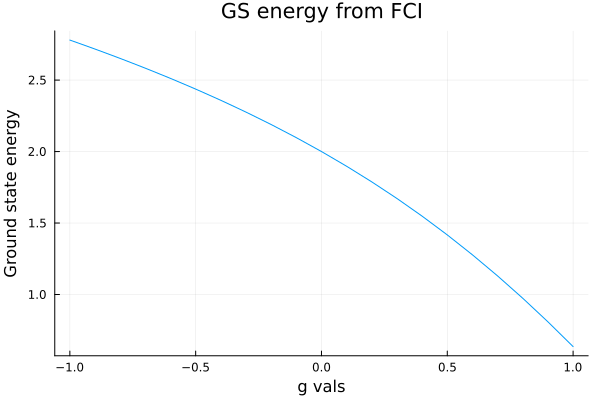

In [407]:

g_vals = range(-1,1,21) |> collect


Ham = zeros(length(g_vals))
for (i,g) in enumerate(g_vals)    
    Ham_temp = FCI(g)
    eigvals = eigen(Ham_temp).values
    Ham[i] = minimum(eigvals) #Minimum energy eigen value = GS Energy
end

plot(g_vals, Ham,xlabel="g vals", ylabel="Ground state energy",legend=false,title="GS energy from FCI")

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task 3: Truncated FCI-> CI (excluded 4p4h)</h2>

In [256]:
function H2p2h(g) #This is CI (FCI without 4p4h states)
    diagonal = [2, 4, 6, 6, 8] #4p4h state excluded
    H = zeros(5,5) #Initialize Matrix
    for i in 1:5
        for j in 1:5
            
            if i+j==7 #Along the opposite diagonal (lower left-> upper right) => 0
                H[i,j] = 0
            elseif i-j==0 #Along the diagonal (ϵ_i-g)
                H[i,j]=diagonal[i]-g
            else # -g/2 everywhere else
                H[i,j]=-g/2
            end
            
        end
    end
    return H
end

H2p2h (generic function with 1 method)

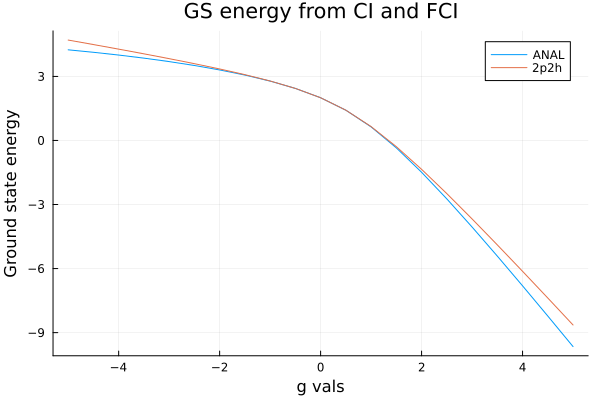

In [454]:
Ham2p2h = zeros(length(g_vals))
Ham_FCI = zeros(length(g_vals))
g_vals = range(-5,5,21) |> collect 

for (i,g) in enumerate(g_vals)   
    
    Ham_temp = H2p2h(g)
    eigvals = eigen(Ham_temp).values
    Ham2p2h[i] = minimum(eigvals) 
    
    Ham_temp = FCI(g)
    eigvals = eigen(Ham_temp).values
    Ham_FCI[i] = minimum(eigvals)
    
end


plot(g_vals, Ham_FCI,xlabel="g vals", ylabel="Ground state energy",label="ANAL",title="GS energy from CI and FCI")
plot!(g_vals, Ham2p2h,xlabel="g vals", ylabel="Ground state energy",label="2p2h")

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task 5: third order MBPT</h2>

In [336]:
function MBPT_3rd_order(g) #Thrid order MBPT theory with 4 contributing diagrams
    #Normally, HF would contribute from diagram 3 as well, since it strictly does not involve calculations with
    #A 1p1h state, but it splits a pair which violates out hamiltonian, and is not included here
    E=0 #Initialize Energy
    Hf_e,E_t = HartreeFock(g) #We start with a Hartree Fock - Basis
    for i in 1:4 # sum over hole states
        for a in 5:8 # sum over particle states
            
            E+=1/4*(-g/2)^2*1/(2*(Hf_e[i]-Hf_e[a]))# Diagram 1
            
            E+=1/4*(-g/2)^3*1/(2*(Hf_e[i]-Hf_e[a]))^2# Diagram 8
            
            for b in 5:8 # Diagram 4, sum over particle states
                 E+=1/8*(-g/2)^3*1/(4*(Hf_e[i]-Hf_e[a])*(Hf_e[i]-Hf_e[b]))
            end
            
            for k in 1:4 # Diagram 5, sum over hole states
                E-=1/8*(-g/2)^3*1/(4*(Hf_e[i]-Hf_e[a])*(Hf_e[k]-Hf_e[a]))
            end
        end
    end
    return E+E_t
end

MBPT_3rd_order (generic function with 1 method)

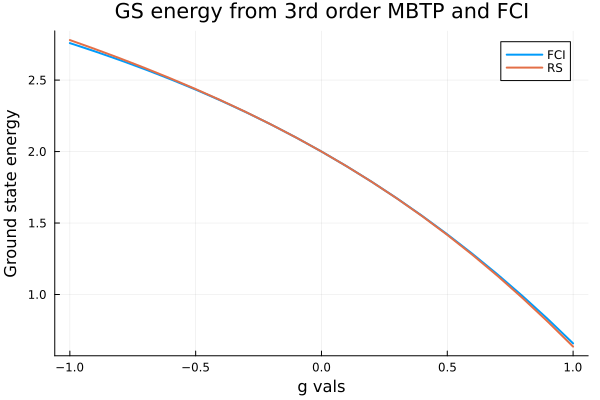

In [403]:

g_vals = range(-1,1,21) |> collect 
Ham2p2h = zeros(length(g_vals))
Ham = zeros(length(g_vals))
for (i,g) in enumerate(g_vals)    
    Ham_temp = FCI(g)

    eigvals = eigen(Ham_temp).values
    Ham2p2h[i] = minimum(eigvals)
end

for (i,g) in enumerate(g_vals)    
    Ham[i] =MBPT_3rd_order(g)
end

plot(g_vals, Ham,xlabel="g vals", ylabel="Ground state energy",label="FCI",lw=2,title="GS energy from 3rd order MBTP and FCI")
plot!(g_vals, Ham2p2h,xlabel="g vals", ylabel="Ground state energy",label="RS",lw=2)


<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task 6: 2nd order MBPT; coefficient comparison</h2>


In [443]:
function MBPT_2ndORDER_Coeffs(g)
    #This funciton only calculates the second order pertubation theory Coefficients to the ground state.
    Hf_e,_ = HartreeFock(g)
    Coeffs = zeros(5)
    c=1
    for i in [3,2] 
        #I iterate over 3-2 because this is equivalent with calling the single-particle energy
        #of state p=2, then, p=1, which is the same as the de-excitation energies we need.
        for a in [6,7]
            #I iterate over 6-7 because this is equivalent with calling the single-particle energy
            #of state p=3, then, p=4, which is the same as the excitation energies we need
            c+=1
            Coeffs[c] =  ((-g/2)*1/(2*(Hf_e[i]-Hf_e[a])))^2
        end
    end
    Coeffs[1] = 1- sum((Coeffs[2:end]))
    return Coeffs
end

function MBPT_2nd_order(g)
    #Calculates the energy for 2nd order MBPT
    E=0 #Initialize Energy
    #We use Hartree fock basis, although is would be easy to calulate manually
    Hf_e,E_t = HartreeFock(g) #We start with a Hartree Fock - Basis
    for i in 1:4 # sum over hole states
        for a in 5:8 # sum over particle states
            
            E+=1/4*(-g/2)^2*1/(2*(Hf_e[i]-Hf_e[a]))# Diagram 1
        end
    end
    return E+E_t
end

MBPT_2nd_order (generic function with 1 method)

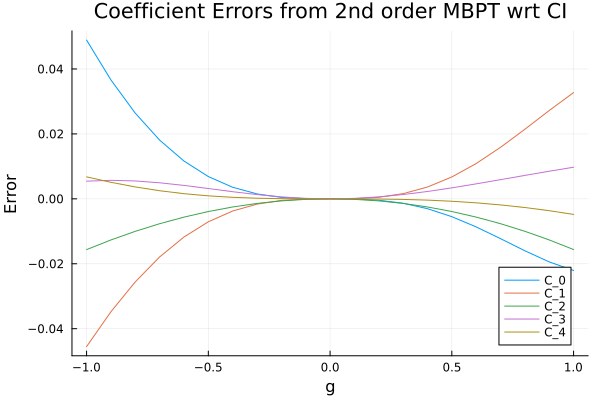

In [452]:
g_vals = range(-1,1,21) |> collect 
Coeff_error = zeros(5, length(g_vals))

for (i,g) in enumerate(g_vals)  
    Ham_temp = H2p2h(g)
    Ham2p2h = eigen(Ham_temp).vectors

    squared_2p2h = (Ham2p2h[1,:]).^2
    Ham_2ndorder = MBPT_2ndORDER_Coeffs(g)
    
    Errors = squared_2p2h.-Ham_2ndorder
    Coeff_error[:,i] = Errors
end   

plot(g_vals, Coeff_error[1,:],label="C_0", title="Coefficient Errors from 2nd order MBPT wrt CI", xlabel="g", ylabel="Error")
plot!(g_vals, Coeff_error[2,:],label="C_1")
plot!(g_vals, Coeff_error[3,:],label="C_2")
plot!(g_vals, Coeff_error[4,:],label="C_3")
plot!(g_vals, Coeff_error[5,:],label="C_4")

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Task 7: 4th order MBPT</h2>

In [433]:
function MBPT_4th_order(g)
    #We split this into two parts: contributions from 2nd + 3rd and 4th order
    E=0 #Initialize Energy
    #We use Hartree fock basis, although is would be easy to calulate manually
    Hf_e,E_t = HartreeFock(g) #We start with a Hartree Fock - Basis
    for i in 1:4 # sum over hole states
        for a in 5:8 # sum over particle states
            
            E+=1/4*(-g/2)^2*1/(2*(Hf_e[i]-Hf_e[a]))# Diagram 1
            
            E+=1/4*(-g/2)^3*1/(2*(Hf_e[i]-Hf_e[a]))^2# Diagram 8
            
            for b in 5:8 # Diagram 4, sum over particle states
                 E+=1/8*(-g/2)^3*1/(4*(Hf_e[i]-Hf_e[a])*(Hf_e[i]-Hf_e[b]))
            end
            
            for k in 1:4 # Diagram 5, sum over hole states
                E-=1/8*(-g/2)^3*1/(4*(Hf_e[i]-Hf_e[a])*(Hf_e[k]-Hf_e[a]))
            end
        end
    end
    
    #We need to account for diagrams:
    # 5, 6, 14, 15 | 34 - > 40
    for i in 1:4 # sum over hole states
        for a in 5:8 # sum over particle states
            
            E += (-g/2)^4*1/(2^4*(Hf_e[i]-Hf_e[a])^3) #Diagram 38
            
            for j in 1:4
                E += (1/2)^2*(-g/2)^4*1/(2^3*(Hf_e[i]-Hf_e[a])*(Hf_e[i]+Hf_e[j]-2*Hf_e[a])*(Hf_e[j]-Hf_e[a])) #Diagram 35
                E += (1/2)^2*(-g/2)^4*1/(2^3*(Hf_e[i]-Hf_e[a])*(Hf_e[i]+Hf_e[j]-2*Hf_e[a])*(Hf_e[i]-Hf_e[a])) #Diagram 39
                
                for b in 5:8
                    E += 2 * (1/2)^4*(-g/2)^4*1/(2^3*(Hf_e[i]-Hf_e[a])*(Hf_e[j]-Hf_e[a])*(Hf_e[j]-Hf_e[b])) # Diagram 5 and 6 
                    E += 2 * (1/2)^4*(-g/2)^4*1/(2^3*(Hf_e[i]-Hf_e[a])*(Hf_e[j]+Hf_e[i]-Hf_e[a]-Hf_e[b])*(Hf_e[j]-Hf_e[b])) # Diagram 36 and 37 
                end
                
                for k in 1:4
                    E +=  (1/2)^4*(-g/2)^4*1/(2^3*(Hf_e[i]-Hf_e[a])*(Hf_e[j]-Hf_e[a])*(Hf_e[k]-Hf_e[a])) # Diagram 15
                end
            end
            
            for b in 5:8
                E += (1/2)^2*(-g/2)^2*1/(2^3*(Hf_e[i]-Hf_e[a])*(2*Hf_e[i]-Hf_e[a]-Hf_e[b])*(Hf_e[i]-Hf_e[b])) #Diagram 34
                E += (1/2)^2*(-g/2)^4*1/(2^3*(Hf_e[i]-Hf_e[a])*(2*Hf_e[i]-Hf_e[a]-Hf_e[b])*(Hf_e[i]-Hf_e[a])) #Diagram 40
                
                for c in 5:8
                    E += (1/2)^4*(-g/2)^4*1/(2^3*(Hf_e[i]-Hf_e[a])*(Hf_e[i]-Hf_e[b])*(Hf_e[i]-Hf_e[c])) # Diagram 14
                end
            end
        end
    end
    
    return E+E_t
end
    

MBPT_4th_order (generic function with 1 method)

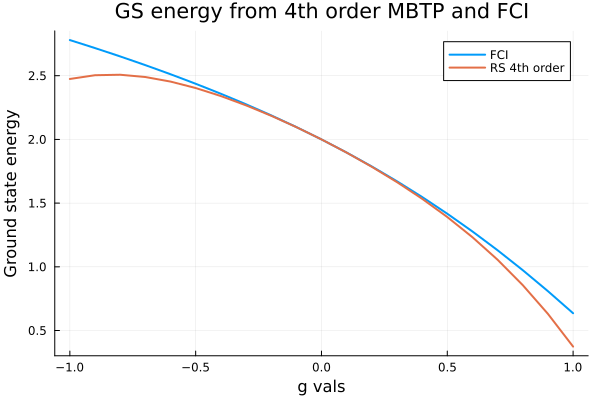

In [447]:

g_vals = range(-1,1,21) |> collect 
MBPT_4 = zeros(length(g_vals))
Ham_FCI = zeros(length(g_vals))

for (i,g) in enumerate(g_vals)    
    Ham_temp = FCI(g)

    eigvals = eigen(Ham_temp).values
    Ham_FCI[i] = minimum(eigvals)
   
    MBPT_4[i] =MBPT_4th_order(g)
end

plot(g_vals, Ham_FCI,xlabel="g vals", ylabel="Ground state energy",label="FCI",lw=2,title="GS energy from 4th order MBTP and FCI")
plot!(g_vals, MBPT_4,xlabel="g vals", ylabel="Ground state energy",label="RS 4th order",lw=2)

In [448]:
g_vals = range(-1,1,21) |> collect 

MBPT_4 = zeros(length(g_vals))
MBPT_3 = zeros(length(g_vals))
MBPT_2 = zeros(length(g_vals))
Ham_FCI = zeros(length(g_vals))
Ham2p2h = zeros(length(g_vals))

for (i,g) in enumerate(g_vals)    
    Ham_temp = H2p2h(g)
    eigvals = eigen(Ham_temp).values
    Ham2p2h[i] = minimum(eigvals)
  
    Ham_temp = FCI(g)
    eigvals = eigen(Ham_temp).values
    Ham_FCI[i] = minimum(eigvals)
    MBPT_2[i] = MBPT_2nd_order(g)
    MBPT_4[i] = MBPT_4th_order(g)
    MBPT_3[i] = MBPT_3rd_order(g)
end

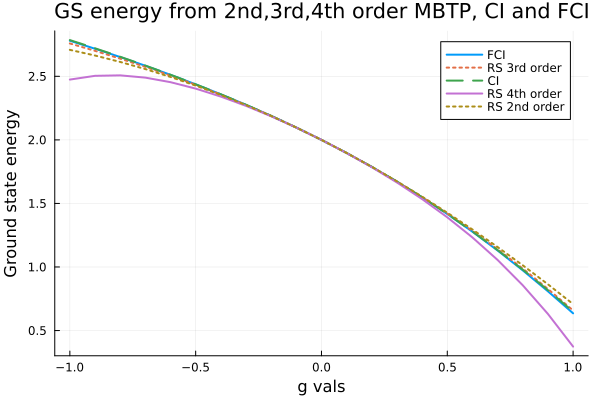

In [451]:
plot(g_vals, Ham_FCI,xlabel="g vals", ylabel="Ground state energy",label="FCI",lw=2,title="GS energy from 2nd,3rd,4th order MBTP, CI and FCI")
plot!(g_vals, MBPT_3,xlabel="g vals", ylabel="Ground state energy",label="RS 3rd order",lw=2,ls=:dot)
plot!(g_vals, Ham2p2h,xlabel="g vals", ylabel="Ground state energy",label="CI",lw=2, ls=:dash)
plot!(g_vals, MBPT_4,xlabel="g vals", ylabel="Ground state energy",label="RS 4th order",lw=2)
plot!(g_vals, MBPT_2,xlabel="g vals", ylabel="Ground state energy",label="RS 2nd order",lw=2,ls=:dot)